In [1253]:
import pandas as pd
import numpy as np
import random as rd
import cv2
from matplotlib import pyplot as plt
from google.colab import drive
import random as rd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1254]:
def crop_image(image):
    img_crop = image[6:-6, 6:-6]   # agora é 36x36
    return img_crop

In [1255]:
df = pd.read_csv("/content/drive/MyDrive/COCADA 2025.2/Projeto Final/ckextended.csv")

* Vamos criar um "Arsenal de Teste". Ou seja, vetores de imagens que são 'hotspots' de emoções. Para cada uma das 7 emoções, vamos criar um vetor com 10 imagens que claramente se encaixam nela.

* Depois isso, a fim de verificar qual emoção uma imagem expressa, vamos projetá-la no PCA-1 de cada uma das imagens e analisar os erros.

* O vetor que retornar o menor erro das projeções é o vetor que indica a emoção mais provável.

In [1256]:
df.value_counts("emotion").sort_index()

,count
emotion,
0,45
1,59
2,25
3,69
4,28
5,83
6,593
7,18


In [1257]:
df["pixels"][0]

'36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 101 107 111 117 122 127 127 130 135 140 138 132 125 108 95 93 69 43 26 18 14 13 7 3 8 21 26 6 4 20 38 20 38 36 41 20 19 9 8 13 11 10 5 23 56 84 97 113 115 111 113 120 126 131 130 137 139 140 141 140 132 119 111 99 88 76 47 22 7 7 8 6 3 5 12 18 4 15 24 55 39 37 41 26 14 11 15 11 14 9 10 43 69 92 106 108 114 121 125 126 127 131 134 131 134 143 147 147 140 129 127 123 115 98 72 47 26 14 8 9 14 3 14 16 21 9 12 49 39 39 40 24 18 15 10 20 17 13 41 63 78 98 105 106 123 124 125 126 133 134 133 137 140 138 142 141 135 133 130 123 119 115 95 69 47 41 22 19 12 19 7 17 31 30 20 32 33 35 39 23 16 13 22 19 13 34 61 69 84 87 98 114 113 117 122 129 132 132 135 134 138 143 142 141 138 132 129 126 122 116 104 84 55 45 31 12 22 16 11 8 13 32 24 17 33 33 34 19 15 19 20 11 26 54 70 76 83 93 98 104 110 118 120 120 127 126 127 130 131 126 131 131 123 122 115 117 110 112 107 99 84 61 51 30 17 7 39 23 22 16 53 8 37 38 35 22 23 23 3 12 41 68 77 81 84 90 94 96 112 118

##**Os pixels das imagens estavam numa string, tive que tranformar em matriz.**

#**LIMPEZA E NORMALIZAÇÃO**

In [1258]:
df = df.sort_values(by="emotion").reset_index(drop=True)

faces = df["pixels"].apply(lambda x: np.array(x.split(), dtype=np.uint8).reshape(48, 48)) # Separa os pixels da string e monta no formato 48x48
faces = np.stack(faces.to_list()) # Tira do formato Series e joga para uma matriz com todas as imagens
size = df["pixels"].apply(lambda x: len(x.split())) #pega o tamanho de todas as imagens
faces = faces[size == 2304] # Descarte de imagens com tamanhos diferentes.


##Normalizando os pixels numa escala [0:1]

In [1259]:
faces_norm = faces.astype("float32") / 255.0

In [1274]:
table = pd.DataFrame({
    "emotion":df["emotion"],
    "pixels": list(faces_norm)
})
table.sort_values("emotion")

,emotion,pixels
0,0,"[[0.13333334, 0.101960786, 0.05882353, 0.07450..."
1,0,"[[0.12941177, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
2,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0117647..."
3,0,"[[0.3882353, 0.3882353, 0.39607844, 0.2784314,..."
4,0,"[[0.011764706, 0.0, 0.007843138, 0.003921569, ..."
...,...,...
909,7,"[[0.8627451, 0.85490197, 0.87058824, 0.8352941..."
908,7,"[[0.1764706, 0.19215687, 0.1882353, 0.20392157..."
907,7,"[[0.8392157, 0.84705883, 0.84313726, 0.8431372..."
906,7,"[[0.33333334, 0.34509805, 0.2784314, 0.2627451..."


In [1261]:
df_angry = table[table["emotion"] == 0]
df_disgust = table[table["emotion"] == 1]
df_fear = table[table["emotion"] == 2]
df_happy = table[table["emotion"] == 3]
df_sad = table[table["emotion"] == 4]
df_surprise = table[table["emotion"] == 5]
df_neutral = table[table["emotion"] == 6]

In [1262]:
faces_angry = df_angry["pixels"]
faces_disgust = df_disgust["pixels"]
faces_fear = df_fear["pixels"]
faces_happy = df_happy["pixels"]
faces_sad = df_sad["pixels"]
faces_surprise = df_surprise["pixels"]
faces_neutral = df_neutral["pixels"]

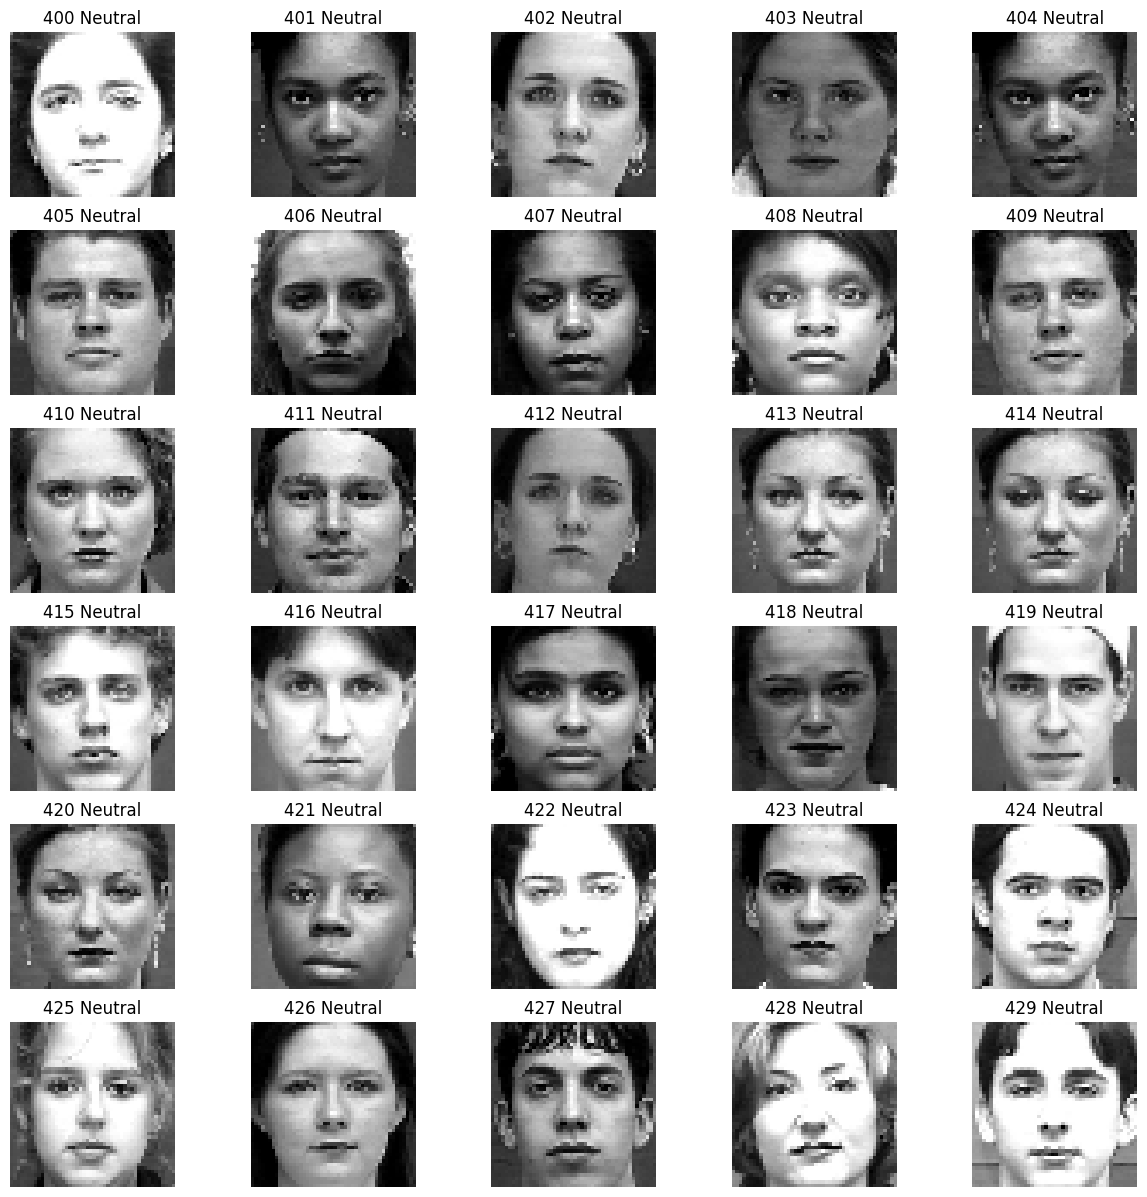

In [1263]:
plt.figure(figsize=(15,15))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear',
              3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

k = 400
for i in range(30):
    img = np.squeeze(faces[i+k])
    emotion = label_dict[df.iloc[i+k]["emotion"]]
    plt.subplot(6, 5, i+1)  # 5 linhas,  colunas
    plt.imshow(img.reshape(48, 48), cmap="gray")
    plt.title(f"{i+k} {emotion}", fontsize=12)
    plt.axis("off")
plt.show()

#**Sorteio:**

Essa é a demonstração de como estão as imagens originalmente.

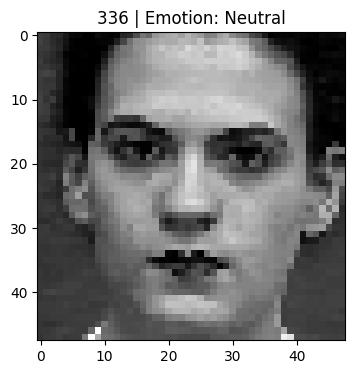

In [1264]:
index = rd.randint(0, 919)

# IMAGEM ORIGINAL
face = faces[index]
emotion = label_dict[df.loc[index]["emotion"]]
plt.figure(figsize=(4, 4))
plt.title(f"{index} | Emotion: {emotion}")
plt.imshow(face, cmap='gray')
#plt.axis("off")
plt.show()

Porém, a fins de otimização e melhora da acurácia do cálculo, reduzi as margens das imagens para operar algebricamente apenas com os pixels mais importantes. Logo após, também normalizei numa escala [0-1]

In [1265]:
faces_crop = np.array([crop_image(image) for image in faces])
faces_crop = faces_crop.astype("float32") / 255.0
faces_crop[10][10:30].max()

np.float32(0.79607844)

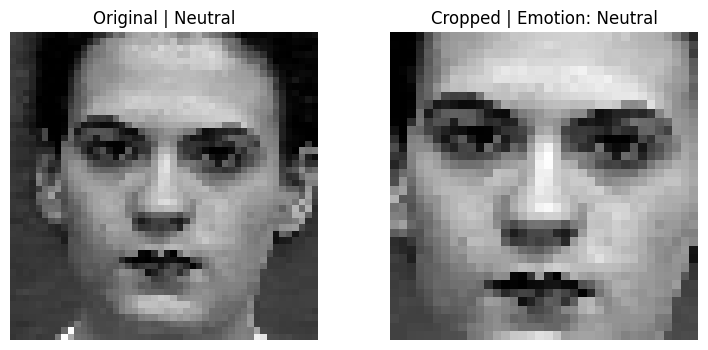

In [1266]:
# IMAGEM CORTADA
teste_crop = faces_crop[index]

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.title(f"Original | {emotion}")
plt.imshow(face, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Cropped | Emotion: {emotion}")
plt.imshow(teste_crop, cmap="gray")
plt.axis("off")

plt.show()

Agora vamos calcular os PCA's das matriz 'representantes' das emoções e projetar a imagem de teste em cada uma para verificar o menor erro. E, então, determinar a qual grupo aquela imagem pertence.

In [1267]:
lenghts = df.groupby("emotion").count()["pixels"].to_list() # Pega a quantidade de imagens para cada emoção
begin = df.groupby("emotion").head(1).index.to_list() # Pega a primeira ocorrência de cada emoção
begin, lenghts

([0, 45, 104, 129, 198, 226, 309, 902], [45, 59, 25, 69, 28, 83, 593, 18])

**Vamos sortear diferentes combinação de samples de cada emoção e fazer uma espécie de validação cruzada.**

In [1278]:
tests_images = []
for i in range(7):
  index_test = rd.sample(range(begin[i], begin[i] + lenghts[i]), 10) # Sorteia índeces de foto de cada emoção.
  for idx in index_test:
    tests_images.append(table["pixels"][idx].to_list()) # Monta o array com os testes



[[array([[0.01568628, 0.0627451 , 0.05882353, ..., 0.14901961, 0.10196079,
          0.12941177],
         [0.01568628, 0.05490196, 0.04313726, ..., 0.16078432, 0.10588235,
          0.07058824],
         [0.03137255, 0.03529412, 0.03921569, ..., 0.16470589, 0.13333334,
          0.07058824],
         ...,
         [0.09019608, 0.10196079, 0.07450981, ..., 0.05882353, 0.06666667,
          0.08235294],
         [0.05490196, 0.04705882, 0.14509805, ..., 0.01960784, 0.02352941,
          0.03921569],
         [0.1254902 , 0.10196079, 0.10980392, ..., 0.        , 0.06666667,
          0.07450981]], dtype=float32),
  array([[0.05098039, 0.08627451, 0.08235294, ..., 0.14117648, 0.28235295,
          0.34901962],
         [0.08235294, 0.06666667, 0.06666667, ..., 0.3019608 , 0.2       ,
          0.35686275],
         [0.08627451, 0.05490196, 0.07058824, ..., 0.24313726, 0.23529412,
          0.34509805],
         ...,
         [0.25490198, 0.2509804 , 0.25490198, ..., 0.29803923, 0.31764707

TypeError: Invalid shape (10, 48, 48) for image data

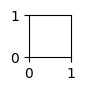

In [1275]:
k = 70
for i in range(70):
    img = np.squeeze(tests_images[i])
    emotion = label_dict[table.iloc[i]["emotion"]]
    plt.subplot(7, 10, i+1)  # 5 linhas,  colunas
    plt.imshow(img, cmap="gray")
    plt.title(f"{i} {emotion}", fontsize=12)
    plt.axis("off")
plt.show()